Prepare Model with saved weight and bias

In [1]:
import torch.nn as nn
import torch
from torchvision import transforms

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=0), #[1, 28, 28] -> [8, 26, 26]
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size = 3, stride = 2), #[8, 26, 26] -> [8, 12, 12] 
            nn.Dropout(0.25))

        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=0), #[8, 12, 12] -> [16, 10, 10]
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=3, stride=2) #[16, 10, 10] -> [16, 4, 4]
        )

        self.classifier = nn.Sequential(
            nn.Linear(256, 50),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(50, 10)
        )

        self.gradient = None
        self.relu = nn.ReLU()
        self.resize = transforms.Resize(28)
        self.flatten = nn.Flatten()

    def forward(self, x):
       z = self.layer1(x)
       z = self.layer2(z)
       h = z.register_hook(self.hook_activation)
       z = self.flatten(z)
       z = self.classifier(z)
       return z
    
    def get_activations(self, x):
        with torch.no_grad():
            x = self.layer1(x)
            return self.layer2(x)
        
    def hook_activation(self, grad):
        self.gradient = grad
    
modifiedNet = Net()
modifiedNet.load_state_dict(torch.load('models/Model.pt'))
modifiedNet.eval()

/home/ble/miniconda3/envs/mlops/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Net(
  (layer1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=50, out_features=10, bias=True)
  )
  (relu): ReLU()
  (resize): Resize(size=28, interpolation=bilinear, max_size=None, antialias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

Load Testing data

In [9]:
import torch
import numpy as np

class MNIST_Dataset(torch.utils.data.Dataset):
  # 784 tab-delim pixel values (0-255) then label (0-9)
  def __init__(self, src_file, transform = None):
    all_xy = np.loadtxt(src_file, usecols=range(785),
      delimiter="\t", comments="#", dtype=np.float32)

    self.transform = transform
    tmp_x = all_xy[:, 0:784]  # all rows, cols [0,783]
    tmp_x /= 255
    tmp_x = tmp_x.reshape(-1, 1, 28, 28)
    tmp_y = all_xy[:, 784]

    self.x_data = \
      torch.tensor(tmp_x, dtype=torch.float32)
    self.y_data = \
      torch.tensor(tmp_y, dtype=torch.int64)
     

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx):
    lbl = self.y_data[idx]  # no use labels
    pixels = self.x_data[idx]

    if self.transform:
      pixels = self.transform(pixels) 
    return (pixels, lbl)
  
test_ds = MNIST_Dataset("dataset/testSet.txt")
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=True)

Performance Metrics Calculation

In [10]:
# Accuracy
n_correct = 0

for data in test_loader:
    (image, lbl) = data
    # with torch.no_grad():
    output = modifiedNet(image)
    (_, preds) = torch.max(output, 1)
    n_correct += (preds == lbl).sum().item()

acc = (n_correct * 1.0) / len(test_ds)
print(f"Accuracy of the model is {acc*100}%")


Accuracy of the model is 98.4%


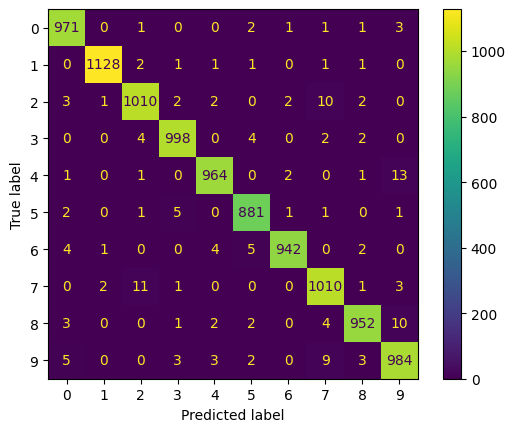

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

all_preds = []
all_lbl = []

for data in test_loader:
    (image, lbl) = data
    # with torch.no_grad():
    output = modifiedNet(image)
    (_, preds) = torch.max(output, 1)
    temp_preds = [x.item() for x in preds]
    temp_lbl = [x.item() for x in lbl]
    all_preds += temp_preds
    all_lbl += temp_lbl

cm = confusion_matrix(all_lbl, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

# macro averaged
# metrik di kalkulasikan per kelas kemudian di rata-ratakan

print(f"Macro Averaged Precision: {precision_score(all_lbl, all_preds, average='macro')}")
print(f"Macro Averaged Recall: {recall_score(all_lbl, all_preds, average='macro')}")
print(f"Macro Averaged F1: {f1_score(all_lbl, all_preds, average='macro')}")

# micro averaged
# masing masing TP, FP, TN, dan FN dikalkulasi untuk setiap kelas kemudian dicari metriknya

print(f"Micro Averaged Precision: {precision_score(all_lbl, all_preds, average='micro')}")
print(f"Micro Averaged Recall: {recall_score(all_lbl, all_preds, average='micro')}")
print(f"Micro Averaged F1: {f1_score(all_lbl, all_preds, average='micro')}")


Macro Averaged Precision: 0.9839496512900032
Macro Averaged Recall: 0.983921266567242
Macro Averaged F1: 0.9839236921478494
Micro Averaged Precision: 0.984
Micro Averaged Recall: 0.984
Micro Averaged F1: 0.984


GradCAM

In [13]:
def get_grad_cam(model, image, label, size):
    
    # forward step
    output = model(image)
    # backward with respect to label
    # print(output[:,label])
    output[:,label].backward()
    #######################
    activations = model.get_activations(image)
    weights = torch.sum(model.gradient, axis=[0, 2, 3])
    scalar_prod = torch.tensordot(weights, activations, dims=([0], [1]))
    scalar_prod = model.relu(scalar_prod)
    scalar_prod /= torch.max(scalar_prod)
    return model.resize(scalar_prod)
    print(scalar_prod.shape)



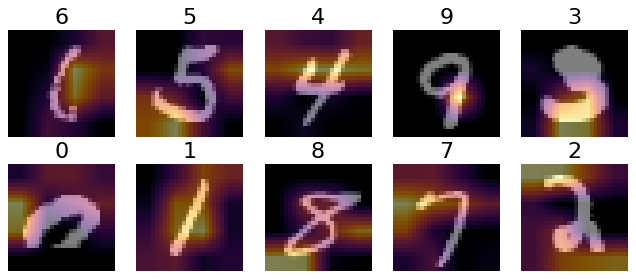

In [43]:
fig = plt.figure(figsize=(10, 4), dpi=80)
columns = 5
rows = 2

tensors = []
classes = []
for data in test_loader:
    pixels, lbl = data
    pixels = pixels.squeeze(0)
    if not lbl in classes:
        tensors.append((pixels, lbl))
        classes.append(lbl)
        # print(f"appending class {lbl}")
    if len(classes) == 10:
        # print("done getting examples")
        break

i=1
for sample_image, label in tensors:
    sample_image = sample_image.unsqueeze(0)

    fig.add_subplot(rows, columns, i)
    i += 1
    plt.imshow(sample_image.view(-1,28,28).permute(1,2,0), cmap='gray')
    plt.title(f"{label.item()}", fontsize=20)
    plt.imshow(get_grad_cam(modifiedNet, sample_image, label, 28).permute(1,2,0), cmap='inferno', alpha=0.5)
    plt.axis('off')

plt.show()